In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 2
commitnumber = 47e1a90
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [-2, -2, 0]
ng_refs = [2, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
vmax = 540
vmin = 340
w_diffuse = [(1.66, 1.66), (1.8, 1.8, 1.8), (1.8, 1.66, 1.45, 1.45, 1.45, 1.45)]
wgt = [(0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6, 0.6, 0.6, 0.6)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

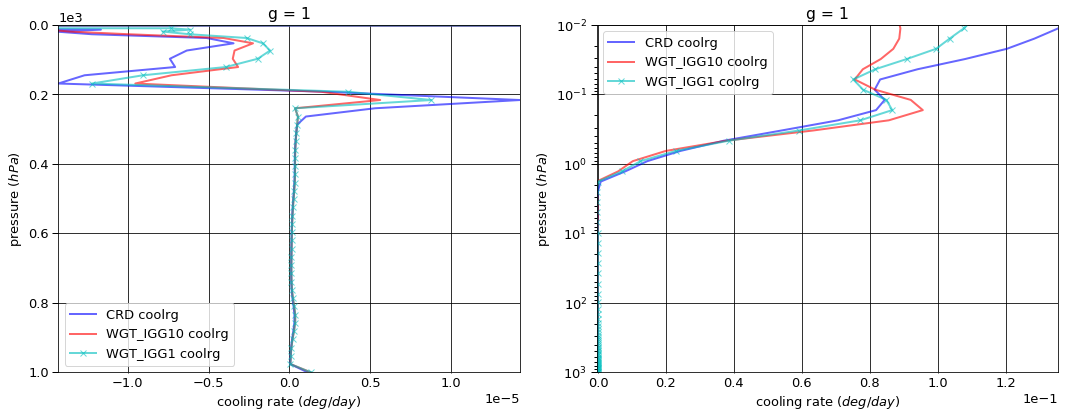

# Figure: cooling rate g-group 2

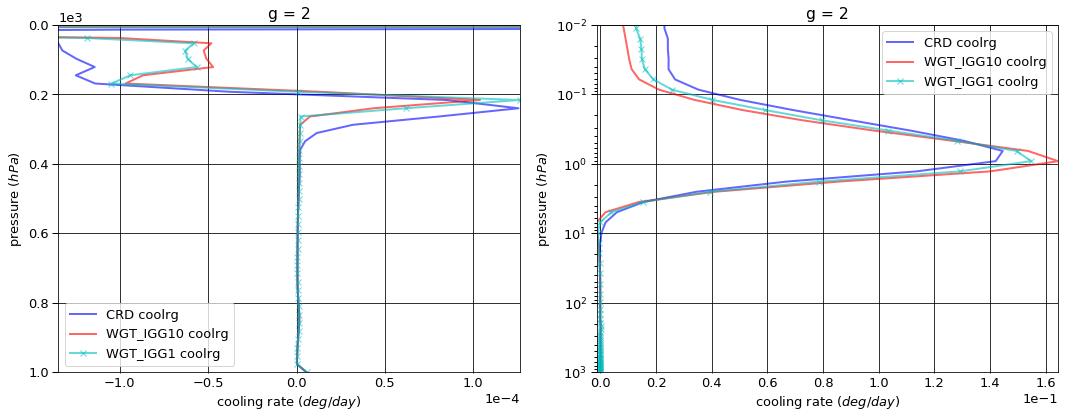

# Figure: cooling rate g-group 3

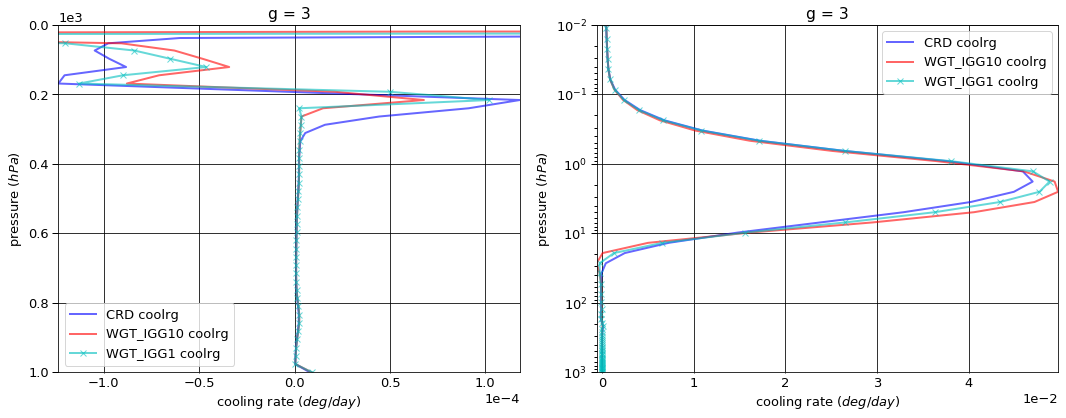

# Figure: cooling rate g-group 4

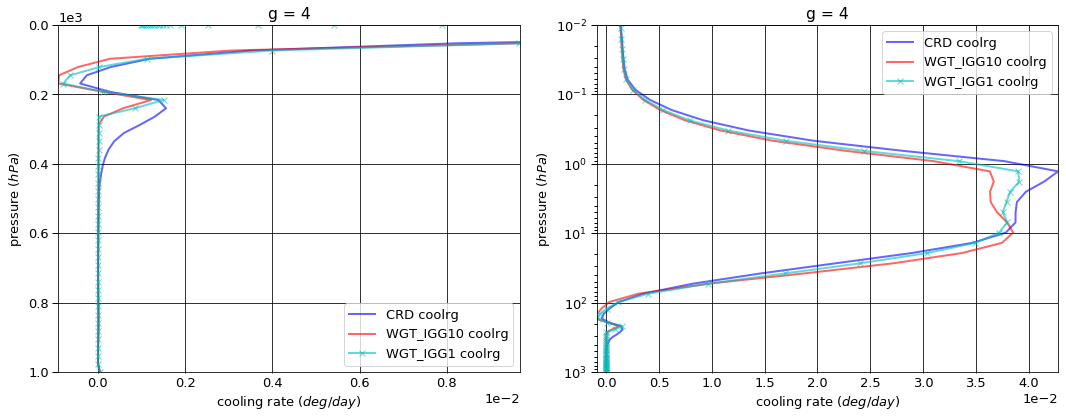

# Figure: cooling rate g-group 5

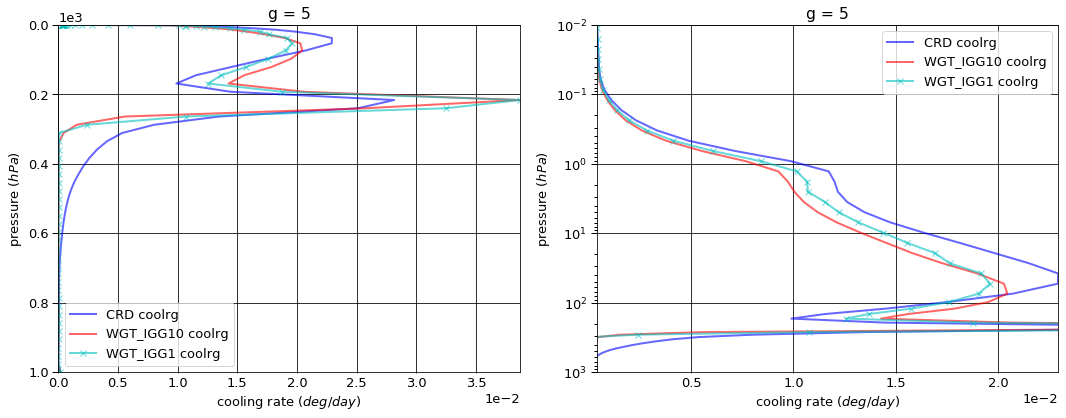

# Figure: cooling rate g-group 6

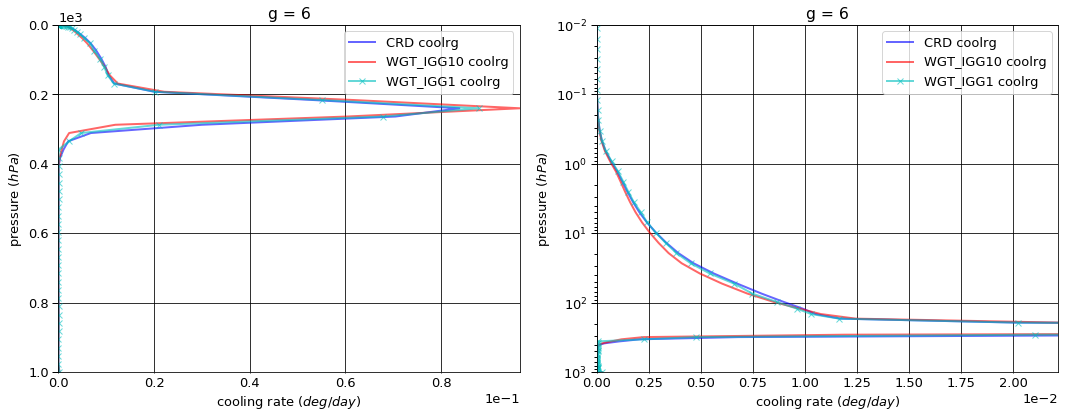

# Figure: cooling rate g-group 7

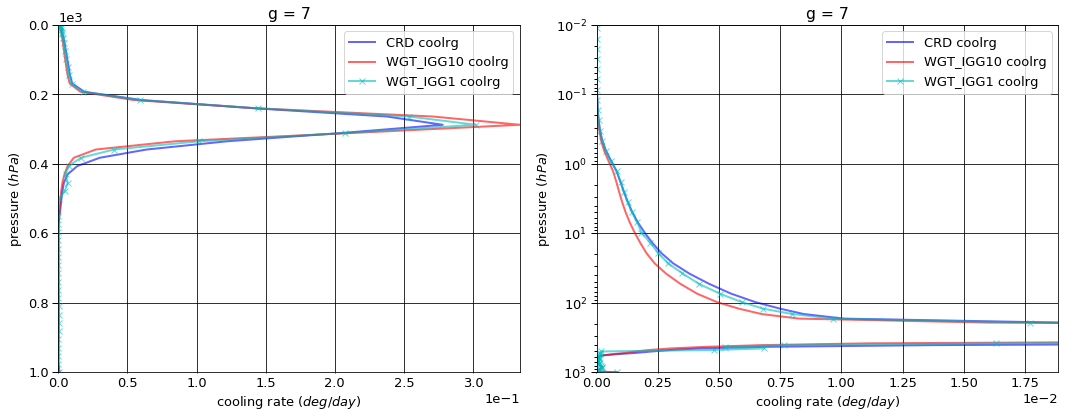

# Figure: cooling rate g-group 8

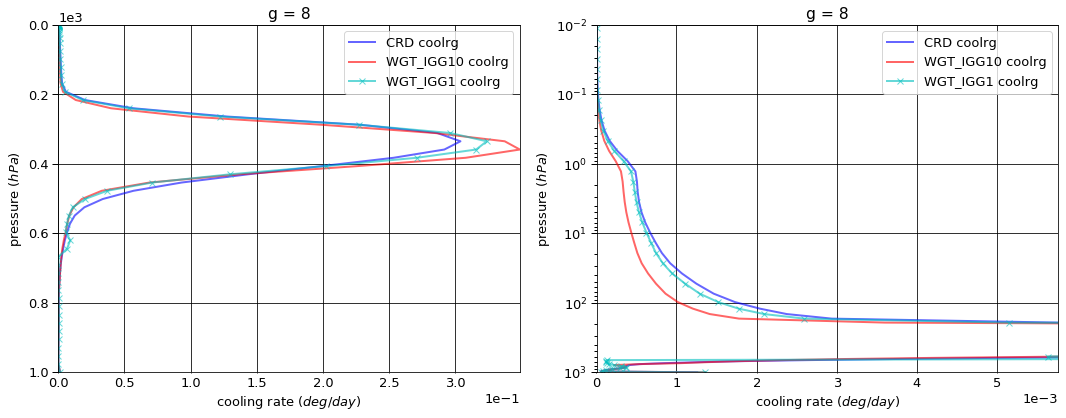

# Figure: cooling rate g-group 9

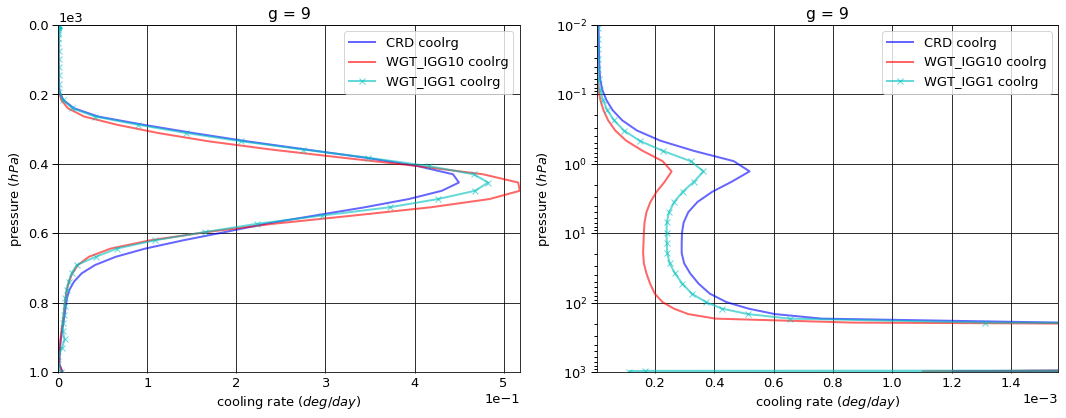

# Figure: cooling rate g-group 10

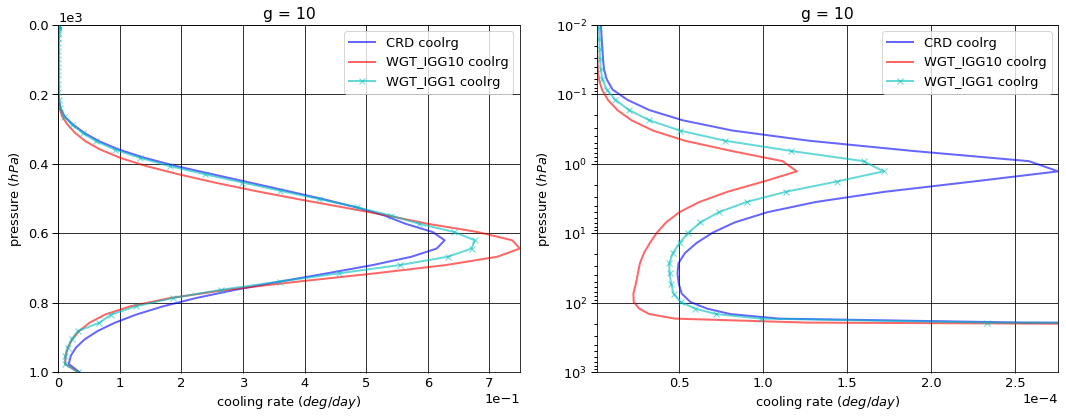

# Figure: cooling rate g-group 11

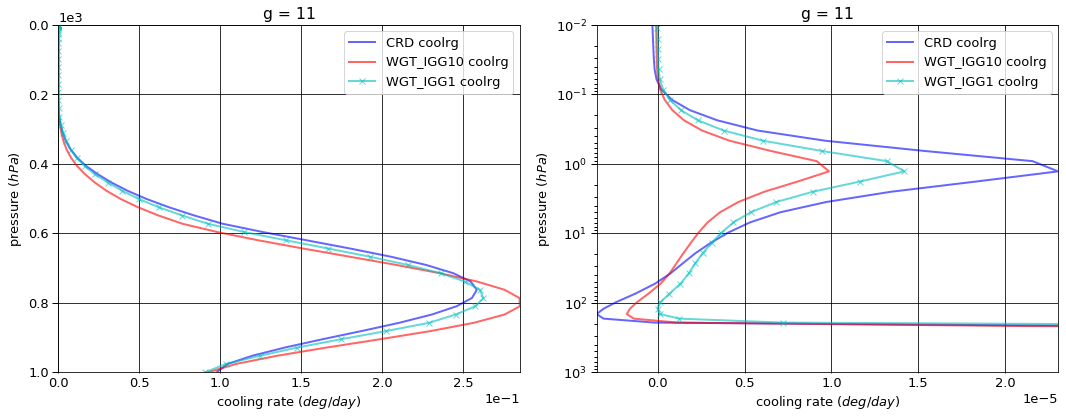

# Figure: cooling rate g-group total

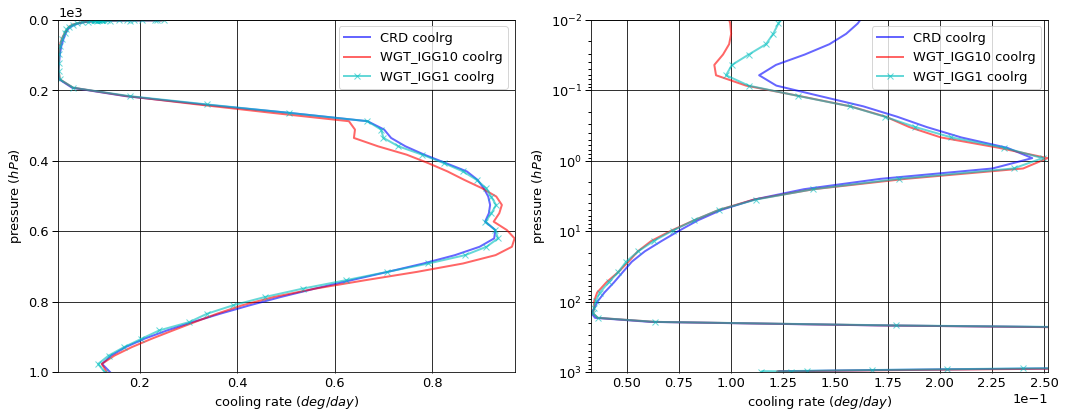

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005610   0.000000  -0.005610
   1013.0   76     -0.009312   0.009309  -0.000003
2  0.0      1      -0.030833   0.000000  -0.030833
   1013.0   76     -0.042357   0.042342  -0.000015
3  0.0      1      -0.042748   0.000000  -0.042748
   1013.0   76     -0.064365   0.064343  -0.000022
4  0.0      1      -0.187066   0.000000  -0.187066
   1013.0   76     -0.349362   0.349239  -0.000122
5  0.0      1      -0.682544   0.000000  -0.682544
   1013.0   76     -1.364499   1.363985  -0.000514
6  0.0      1      -0.932411   0.000000  -0.932411
   1013.0   76     -1.801958   1.801336  -0.000621
7  0.0      1      -3.492238   0.000000  -3.492238
   1013.0   76     -6.186713   6.184545  -0.002167
8  0.0      1      -6.142731   0.000000  -6.142731
   1013.0   76     -9.838320   9.834835  -0.003484
9  0.0      1     -13.470015   0.000000 -13.470015
   1013.0   76    -19.192648  19.180315  -0.012333
10 0.0      1     -23.634384   0.000000 -23.634384
   1013.0   76    -30.006619  29.899553  -0.107065
11 0.0      1     -11.694789   0.000000 -11.694789
   1013.0   76    -13.459642  12.627265  -0.832377


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005367   0.000000  -0.005367
   1013.0   76     -0.009767   0.009764  -0.000004
2  0.0      1      -0.032140   0.000000  -0.032140
   1013.0   76     -0.042881   0.042865  -0.000016
3  0.0      1      -0.043666   0.000000  -0.043666
   1013.0   76     -0.066645   0.066620  -0.000025
4  0.0      1      -0.181978   0.000000  -0.181978
   1013.0   76     -0.359209   0.359074  -0.000134
5  0.0      1      -0.636173   0.000000  -0.636173
   1013.0   76     -1.401993   1.401469  -0.000524
6  0.0      1      -0.896839   0.000000  -0.896839
   1013.0   76     -1.864737   1.864040  -0.000697
7  0.0      1      -3.417287   0.000000  -3.417287
   1013.0   76     -6.361017   6.358638  -0.002379
8  0.0      1      -6.124729   0.000000  -6.124729
   1013.0   76    -10.071241  10.067476  -0.003766
9  0.0      1     -13.552988   0.000000 -13.552988
   1013.0   76    -19.425263  19.413140  -0.012123
10 0.0      1     -23.750024   0.000000 -23.750024
   1013.0   76    -29.846917  29.756052  -0.090865
11 0.0      1     -11.452291   0.000000 -11.452291
   1013.0   76    -12.866124  12.368113  -0.498011


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005409   0.000000  -0.005409
   1013.0   76     -0.009767   0.009764  -0.000004
2  0.0      1      -0.031734   0.000000  -0.031734
   1013.0   76     -0.042881   0.042865  -0.000016
3  0.0      1      -0.043203   0.000000  -0.043203
   1013.0   76     -0.066645   0.066620  -0.000025
4  0.0      1      -0.181175   0.000000  -0.181175
   1013.0   76     -0.359209   0.359074  -0.000134
5  0.0      1      -0.642199   0.000000  -0.642199
   1013.0   76     -1.401993   1.401469  -0.000524
6  0.0      1      -0.903365   0.000000  -0.903365
   1013.0   76     -1.864737   1.864040  -0.000697
7  0.0      1      -3.421418   0.000000  -3.421418
   1013.0   76     -6.361017   6.358638  -0.002379
8  0.0      1      -6.074283   0.000000  -6.074283
   1013.0   76    -10.071241  10.067476  -0.003766
9  0.0      1     -13.425626   0.000000 -13.425626
   1013.0   76    -19.425263  19.417999  -0.007264
10 0.0      1     -23.523242   0.000000 -23.523242
   1013.0   76    -29.846917  29.754256  -0.092661
11 0.0      1     -11.349291   0.000000 -11.349291
   1013.0   76    -12.866124  12.309123  -0.557002


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000243  0.000000  2.434710e-04
   1013.0   76    -0.000455  0.000455 -5.495881e-07
2  0.0      1     -0.001307  0.000000 -1.307290e-03
   1013.0   76    -0.000524  0.000523 -6.402510e-07
3  0.0      1     -0.000918  0.000000 -9.175840e-04
   1013.0   76    -0.002280  0.002277 -2.754434e-06
4  0.0      1      0.005088  0.000000  5.088040e-03
   1013.0   76    -0.009847  0.009835 -1.191191e-05
5  0.0      1      0.046370  0.000000  4.637048e-02
   1013.0   76    -0.037494  0.037484 -1.028699e-05
6  0.0      1      0.035572  0.000000  3.557220e-02
   1013.0   76    -0.062779  0.062704 -7.589444e-05
7  0.0      1      0.074951  0.000000  7.495100e-02
   1013.0   76    -0.174304  0.174093 -2.111113e-04
8  0.0      1      0.018001  0.000000  1.800140e-02
   1013.0   76    -0.232921  0.232641 -2.814157e-04
9  0.0      1     -0.082973  0.000000 -8.297300e-02
   1013.0   76    -0.232615  0.232825  2.102230e-04
10 0.0      1     -0.115640  0.000000 -1.156400e-01
   1013.0   76     0.159702 -0.143501  1.620060e-02
11 0.0      1      0.242498  0.000000  2.424980e-01
   1013.0   76     0.593518 -0.259152  3.343666e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000202  0.000000  2.015859e-04
   1013.0   76    -0.000455  0.000455 -5.495881e-07
2  0.0      1     -0.000901  0.000000 -9.009090e-04
   1013.0   76    -0.000524  0.000523 -6.402510e-07
3  0.0      1     -0.000454  0.000000 -4.544800e-04
   1013.0   76    -0.002280  0.002277 -2.754434e-06
4  0.0      1      0.005891  0.000000  5.890940e-03
   1013.0   76    -0.009847  0.009835 -1.191191e-05
5  0.0      1      0.040345  0.000000  4.034475e-02
   1013.0   76    -0.037494  0.037484 -1.028699e-05
6  0.0      1      0.029046  0.000000  2.904624e-02
   1013.0   76    -0.062779  0.062704 -7.589444e-05
7  0.0      1      0.070820  0.000000  7.081990e-02
   1013.0   76    -0.174304  0.174093 -2.111113e-04
8  0.0      1      0.068448  0.000000  6.844790e-02
   1013.0   76    -0.232921  0.232641 -2.814157e-04
9  0.0      1      0.044389  0.000000  4.438900e-02
   1013.0   76    -0.232615  0.237684  5.069962e-03
10 0.0      1      0.111142  0.000000  1.111420e-01
   1013.0   76     0.159702 -0.145297  1.440460e-02
11 0.0      1      0.345498  0.000000  3.454980e-01
   1013.0   76     0.593518 -0.318142  2.753759e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.366357e-01
   1001.112500 75     1.121112e-06
2  0.000312    1      1.652764e-02
   1001.112500 75     5.560166e-06
3  0.000312    1      2.279429e-04
   1001.112500 75     8.007919e-06
4  0.000312    1      9.737327e-04
   1001.112500 75     4.421842e-05
5  0.000312    1      2.942058e-04
   1001.112500 75     1.856869e-04
6  0.000312    1      1.712511e-06
   1001.112500 75     2.244871e-04
7  0.000312    1      5.453592e-06
   1001.112500 75     7.829797e-04
8  0.000312    1      6.469260e-06
   1001.112500 75     1.258684e-03
9  0.000312    1      6.854901e-06
   1001.112500 75     4.869643e-03
10 0.000312    1      8.751541e-07
   1001.112500 75     3.459302e-02
11 0.000312    1     -4.773480e-07
   1001.112500 75     9.761873e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      7.270902e-02
   1001.112500 75     1.318984e-06
2  0.000312    1      2.930834e-03
   1001.112500 75     5.790592e-06
3  0.000312    1      2.726682e-04
   1001.112500 75     8.999583e-06
4  0.000312    1      1.001388e-03
   1001.112500 75     4.850684e-05
5  0.000312    1      2.905054e-04
   1001.112500 75     1.893225e-04
6  0.000312    1      1.452961e-06
   1001.112500 75     2.518105e-04
7  0.000312    1      3.989859e-06
   1001.112500 75     8.589795e-04
8  0.000312    1      2.890746e-06
   1001.112500 75     1.360001e-03
9  0.000312    1      2.367119e-06
   1001.112500 75     4.788981e-03
10 0.000312    1     -2.543327e-07
   1001.112500 75     3.259954e-02
11 0.000312    1     -1.736619e-07
   1001.112500 75     9.241108e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      9.670556e-02
   1001.112500 75     1.318984e-06
2  0.000312    1      7.437294e-03
   1001.112500 75     5.790592e-06
3  0.000312    1      2.499281e-04
   1001.112500 75     8.999583e-06
4  0.000312    1      9.909476e-04
   1001.112500 75     4.850684e-05
5  0.000312    1      3.127294e-04
   1001.112500 75     1.893225e-04
6  0.000312    1      1.635320e-06
   1001.112500 75     2.518105e-04
7  0.000312    1      5.089985e-06
   1001.112500 75     8.589795e-04
8  0.000312    1      4.535371e-06
   1001.112500 75     1.360001e-03
9  0.000312    1      4.473205e-06
   1001.112500 75     2.623150e-03
10 0.000312    1      5.809063e-07
   1001.112500 75     3.257259e-02
11 0.000312    1     -1.540886e-07
   1001.112500 75     9.057862e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -6.392669e-02
   1001.112500 75     1.978721e-07
2  0.000312    1     -1.359680e-02
   1001.112500 75     2.304263e-07
3  0.000312    1      4.472524e-05
   1001.112500 75     9.916639e-07
4  0.000312    1      2.765553e-05
   1001.112500 75     4.288421e-06
5  0.000312    1     -3.700410e-06
   1001.112500 75     3.635550e-06
6  0.000312    1     -2.595502e-07
   1001.112500 75     2.732342e-05
7  0.000312    1     -1.463734e-06
   1001.112500 75     7.599979e-05
8  0.000312    1     -3.578513e-06
   1001.112500 75     1.013166e-04
9  0.000312    1     -4.487783e-06
   1001.112500 75    -8.066210e-05
10 0.000312    1     -1.129487e-06
   1001.112500 75    -1.993485e-03
11 0.000312    1      3.036862e-07
   1001.112500 75    -5.207658e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.993015e-02
   1001.112500 75     1.978721e-07
2  0.000312    1     -9.090344e-03
   1001.112500 75     2.304263e-07
3  0.000312    1      2.198520e-05
   1001.112500 75     9.916639e-07
4  0.000312    1      1.721497e-05
   1001.112500 75     4.288421e-06
5  0.000312    1      1.852356e-05
   1001.112500 75     3.635550e-06
6  0.000312    1     -7.719140e-08
   1001.112500 75     2.732342e-05
7  0.000312    1     -3.636068e-07
   1001.112500 75     7.599979e-05
8  0.000312    1     -1.933889e-06
   1001.112500 75     1.013166e-04
9  0.000312    1     -2.381697e-06
   1001.112500 75    -2.246493e-03
10 0.000312    1     -2.942477e-07
   1001.112500 75    -2.020430e-03
11 0.000312    1      3.232595e-07
   1001.112500 75    -7.040114e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.315369,0.000000,-60.315369
1013.0,76,-82.315794,81.357068,-0.958727



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.093482,0.000000,-60.093482
1013.0,76,-82.315794,81.707251,-0.608544



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-59.600944,0.000000,-59.600944
1013.0,76,-82.315794,81.651324,-0.664471



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.218867e-01,0.000000,0.221887
1013.0,76,9.669999e-08,0.350183,0.350183



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,7.144249e-01,0.000000,0.714425
1013.0,76,9.669999e-08,0.294256,0.294256


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.154680
1001.112500,75,0.139592



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.077215
1001.112500,75,0.132524



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.105713
1001.112500,75,0.128499



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.077465
1001.112500,75,-0.007068



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.048967
1001.112500,75,-0.011093


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000119
2,0.000525,0.000521
3,0.000840,0.000810
4,0.004490,0.004364
5,0.017520,0.017032
6,0.023475,0.022653
7,0.079385,0.077276
8,0.125500,0.122349
9,0.238215,0.235985


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.013979e-17
2,7.376594e-19
3,4.606445e-19
4,3.437534e-20
5,2.565240e-21
6,2.180272e-20
7,3.897251e-21
8,6.966363e-22
9,1.245242e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.013979e-17,NaN,0.000125,0.000119,0.000125,0.000119,1.0
2,7.376594e-19,0.072749,0.000525,0.000521,0.000650,0.000640,1.0
3,4.606445e-19,0.624468,0.000840,0.000810,0.001490,0.001449,10.0
4,3.437534e-20,0.074624,0.004490,0.004364,0.005980,0.005813,10.0
5,2.565240e-21,0.074624,0.017520,0.017032,0.023500,0.022845,10.0
6,2.180272e-20,8.499291,0.023475,0.022653,0.046975,0.045498,500.0
7,3.897251e-21,0.178751,0.079385,0.077276,0.126360,0.122774,500.0
8,6.966363e-22,0.178751,0.125500,0.122349,0.251860,0.245123,500.0
9,1.245242e-22,0.178751,0.238215,0.235985,0.490075,0.481108,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
